In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from collections import deque 
import json 
from loguru import logger

from utils.tool import *

In [2]:
edges_file = 'E:\\学习\\数模相关\\code_of_argorithm\\深圳杯C题\\edges_info.json' 
nodes_file = 'E:\\学习\\数模相关\\code_of_argorithm\\深圳杯C题\\nodes_info.json'

#打开文件
with open(edges_file, 'r', encoding='utf-8') as f:
    edges_info = json.load(f)
#因为json文件中存储的边是字符串格式的元组，所以需要将其转换为实际的元组
edges_info = [{tuple(eval(edge)): info for edge, info in edge_dict.items()} for edge_dict in edges_info]

with open(nodes_file, 'r', encoding='utf-8') as f:
    nodes_info = json.load(f)


In [3]:
edges_info

[{(1, 2): {'length': 0.025,
   'type': '普通线',
   '分段开关': 'None',
   '联络开关': 'None',
   'Resistor': 0.0031,
   'Reactance': 0.0021}},
 {(2, 3): {'length': 0.05,
   'type': '普通线',
   '分段开关': 'None',
   '联络开关': 'None',
   'Resistor': 0.0063,
   'Reactance': 0.0042}},
 {(3, 4): {'length': 0.1,
   'type': '普通线',
   '分段开关': 'S1',
   '联络开关': 'None',
   'Resistor': 0.0125,
   'Reactance': 0.0085}},
 {(4, 5): {'length': 0.1,
   'type': '普通线',
   '分段开关': 'None',
   '联络开关': 'None',
   'Resistor': 0.0125,
   'Reactance': 0.0085}},
 {(5, 6): {'length': 1.21,
   'type': '普通线',
   '分段开关': 'S2',
   '联络开关': 'None',
   'Resistor': 0.203,
   'Reactance': 0.1034}},
 {(6, 7): {'length': 1.7,
   'type': '普通线',
   '分段开关': 'None',
   '联络开关': 'None',
   'Resistor': 0.2842,
   'Reactance': 0.1447}},
 {(7, 8): {'length': 4.25,
   'type': '普通线',
   '分段开关': 'S3',
   '联络开关': 'None',
   'Resistor': 0.3105,
   'Reactance': 0.3619}},
 {(8, 9): {'length': 1.21,
   'type': '普通线',
   '分段开关': 'None',
   '联络开关': 'None',
  

In [4]:
nodes_info

{'1': {'type': '居民', 'DG': False, 'power': 40.0, 'which_substation': 'CB1'},
 '2': {'type': '居民', 'DG': False, 'power': 60.0, 'which_substation': 'CB1'},
 '3': {'type': '居民', 'DG': False, 'power': 60.0, 'which_substation': 'CB1'},
 '4': {'type': '居民', 'DG': False, 'power': 60.0, 'which_substation': 'CB1'},
 '5': {'type': '居民', 'DG': False, 'power': 100.0, 'which_substation': 'CB1'},
 '6': {'type': '居民', 'DG': False, 'power': 60.0, 'which_substation': 'CB1'},
 '7': {'type': '办公和建筑', 'DG': False, 'power': 60.0, 'which_substation': 'CB1'},
 '8': {'type': '居民', 'DG': False, 'power': 60.0, 'which_substation': 'CB1'},
 '9': {'type': '政府和机构',
  'DG': False,
  'power': 120.0,
  'which_substation': 'CB1'},
 '10': {'type': '居民', 'DG': False, 'power': 200.0, 'which_substation': 'CB1'},
 '11': {'type': '商业', 'DG': False, 'power': 150.0, 'which_substation': 'CB1'},
 '12': {'type': '办公和建筑',
  'DG': False,
  'power': 200.0,
  'which_substation': 'CB1'},
 '13': {'type': '居民', 'DG': False, 'power': 60.

In [5]:
import logging

class RiskAnalyzer:  
    def __init__(self, nodes_info:dict[str, dict], edges_info:list[dict[tuple,dict]]):
        self.logger = logging.getLogger("RiskAnalyzer")
        self.logger.info("正在初始化RiskAnalyzer...")
        self.nodes_info = nodes_info.copy()  # 深拷贝节点信息
        self.edges_info = edges_info.copy()  # 深拷贝边信息 
        self.graph = UndirectedGraph(nodes_info, edges_info)  # 创建无向图对象
        self.rated_current = 220  # 额定电流220A
        self.user_weights = {
            "居民": 1.0,
            "商业": 2.5,
            "政府和机构": 3.0,
            "办公和建筑": 2.0  # 新增
        }
        self.logger.info("RiskAnalyzer初始化完成。")

    def capacity(self, u:int, v:int) -> float:
        self.logger.info(f"正在计算边({u}, {v})的容量")
        try:
            assert self.graph.get_edge_attribute(u, v, 'Resistor') is not None, "边(u, v)不存在Resistor属性"
            assert self.graph.get_edge_attribute(u, v, 'Reactance') is not None, "边(u, v)不存在Reactance属性"

            R_val = self.graph.get_edge_attribute(u, v, 'Resistor')
            X_val = self.graph.get_edge_attribute(u, v, 'Reactance')

            if R_val is None or isinstance(R_val, dict):
                self.logger.error(f"边({u}, {v})的Resistor值无效: {R_val}")
                raise ValueError(f"边({u}, {v})的Resistor值无效: {R_val}")
            if X_val is None or isinstance(X_val, dict):
                self.logger.error(f"边({u}, {v})的Reactance值无效: {X_val}")
                raise ValueError(f"边({u}, {v})的Reactance值无效: {X_val}")
            R = float(R_val)
            X = float(X_val)
            Z = np.sqrt(R**2 + X**2)
            V = 10e3
            capacity = (V**2 / Z) * 0.9 
            self.logger.info(f"边({u}, {v})的容量为{capacity}")
            return capacity
        except Exception as e:
            self.logger.error(f"计算边({u}, {v})容量时出错: {e}")
            raise

    def refreash_capacity(self) -> None:
        self.logger.info("正在刷新所有边的容量...")
        try:
            for edge in self.edges_info:
                edge_tuple = list(edge.keys())[0]
                if isinstance(edge_tuple, tuple) and len(edge_tuple) == 2:
                    u, v = edge_tuple
                else:
                    self.logger.error(f"边的key不是包含两个元素的元组: {edge_tuple}")
                    raise ValueError(f"边的key不是包含两个元素的元组: {edge_tuple}")
                capacity = self.capacity(u, v)
                edge[(u, v)]['capacity'] = capacity
                self.logger.info(f"已更新边({u}, {v})的容量: {capacity}")
            self.logger.info("所有边的容量已刷新。")
        except Exception as e:
            self.logger.error(f"刷新容量时出错: {e}")
            raise

    def edmonds_karp(self, source, sink) -> float:
        self.logger.info(f"正在运行Edmonds-Karp算法，源点: {source}，汇点: {sink}")
        max_flow = 0
        parent = {}

        def bfs():
            parent.clear()
            visited = set()
            queue = deque([source])
            visited.add(source)
            while queue:
                u = queue.popleft()
                for v in self.graph.neighbors(u):
                    try:
                        if v not in visited and self.capacity(u, v) > 0:
                            visited.add(v)
                            parent[v] = u
                            queue.append(v)
                            if v == sink:
                                return True
                    except Exception as e:
                        self.logger.error(f"BFS过程中边({u}, {v})出错: {e}")
                        continue
            return False

        try:
            while bfs():
                path_flow = float("inf")
                v = sink
                while v != source:
                    u = parent[v]
                    path_flow = min(path_flow, self.capacity(u, v))
                    v = u
                max_flow += path_flow
                v = sink
                while v != source:
                    u = parent[v]
                    for edge in self.edges_info:
                        key = list(edge.keys())[0]
                        if key == (u, v):
                            edge[key]["capacity"] -= path_flow
                        elif key == (v, u):
                            edge[key]["capacity"] += path_flow
                    v = u
                self.logger.info(f"增广路径流量为{path_flow}，当前最大流: {max_flow}")
            self.logger.info(f"Edmonds-Karp算法结束，最大流: {max_flow}")
            return max_flow
        except Exception as e:
            self.logger.error(f"Edmonds-Karp算法出错: {e}")
            raise

    def failure_probability(self, line:tuple) -> float:  
        self.logger.info(f"正在计算线路{line}的故障概率")
        try:
            u, v = line  
            edge = self.graph.get_edge(u, v)
            line_fault = edge['length'] * 0.002  
            switch_fault = 0.002  
            dg_fault = 0.005 if self.nodes_info[str(u)]['DG'] else 0  
            prob = line_fault + switch_fault + dg_fault  
            self.logger.info(f"线路{line}的故障概率为{prob}")
            return prob
        except Exception as e:
            self.logger.error(f"计算线路{line}故障概率时出错: {e}")
            raise

    def load_loss_risk(self, line) -> float:  
        self.logger.info(f"正在计算线路{line}的失负荷风险")
        try:
            u, v = line 
            u = str(u)
            v = str(v) 
            P_f = self.failure_probability(line)  
            source = self.nodes_info[str(u)]["which_substation"]
            sink = self.nodes_info[str(v)]["which_substation"] 
            L_transfer = self.edmonds_karp(source, sink)  
            L_load = self.nodes_info[u]["power"] + self.nodes_info[str(v)]["power"]  
            L_loss = max(L_load - L_transfer, 0)  
            user_type = self.nodes_info[str(u)]["type"]  
            C_loss = self.user_weights[user_type] * L_loss  
            risk = P_f * C_loss  
            self.logger.info(f"线路{line}的失负荷风险为{risk}")
            return risk
        except Exception as e:
            self.logger.error(f"计算线路{line}失负荷风险时出错: {e}")
            raise

    def overload_risk(self, line) -> float:  
        self.logger.info(f"正在计算线路{line}的过载风险")
        try:
            u, v = line
            u = str(u)
            v = str(v)
            P_dg = self.nodes_info[u]["power"] if self.nodes_info[u]["DG"] else 0  
            P_load = self.nodes_info[u]["power"]  
            P_net = P_dg - P_load  
            if P_net <= 0:  
                self.logger.info(f"线路{line}无过载风险（P_net <= 0）")
                return 0  
            P_transfer_max = 0  
            for neighbor in self.graph.neighbors(u):  
                try:
                    C_ij = self.graph.get_edge_attribute((u, neighbor), "capacity")  
                    P_load_j = self.nodes_info[str(neighbor)]["power"]  
                    P_dg_j = self.nodes_info[str(neighbor)]["power"] if self.nodes_info[str(neighbor)]["DG"] else 0  
                    available = max(P_load_j - P_dg_j, 0)  
                    P_transfer_max += min(C_ij, available)  
                except Exception as e:
                    self.logger.error(f"计算{u}的邻居{neighbor}转移能力时出错: {e}")
                    continue
            overload = max(P_net - P_transfer_max, 0)  
            I = overload * 1e3 / (10e3 * np.sqrt(3) * 0.9)  
            C_over = 100 * max(I - 1.1 * self.rated_current, 0)  
            self.logger.info(f"线路{line}的过载风险为{C_over}")
            return C_over  
        except Exception as e:
            self.logger.error(f"计算线路{line}过载风险时出错: {e}")
            raise

## 问题求解函数

In [6]:
analyzer = RiskAnalyzer(nodes_info, edges_info)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.rich import tqdm
import copy

# 假设这些类和函数已在其他模块中定义：
# from your_module import load_data, PowerGridGraph, RiskAnalyzer
def problem1():
    """问题1：验证一条线路的失负荷与过负荷风险"""
    #nodes, edges = load_data(limit=10)  # 测试用小规模数据
    #grid = PowerGridGraph(nodes, edges)
    analyzer = RiskAnalyzer(nodes_info, edges_info)

    line = (4, 5)
    risk_loss = analyzer.load_loss_risk(line)
    risk_over = analyzer.overload_risk(line)

    print(f"线路 {line} 风险评估：失负荷 = {risk_loss:.2f}，过负荷 = {risk_over:.2f}")

problem1()


节点 CB1 不存在
线路 (4, 5) 风险评估：失负荷 = 0.35，过负荷 = 0.00


e:\学习\数模相关\code_of_argorithm\.venv\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\diego\AppData\Local\Temp\ipykernel_35216\4150962332.py:12: TqdmExperimentalWarning: rich is experimental/alpha
  for cap in tqdm(capacities, desc="问题2：容量模拟中"):


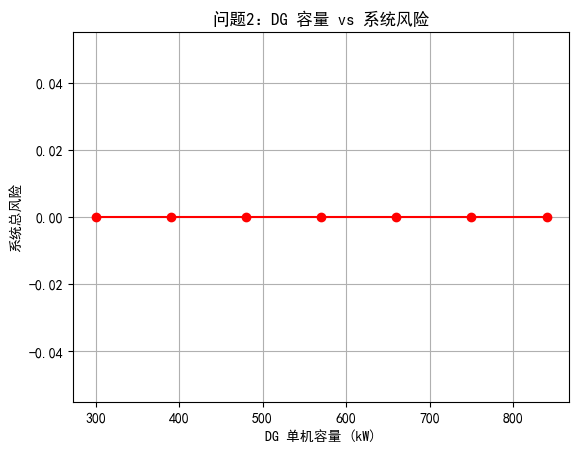

In [8]:
def problem2():
    """问题2：分析 DG 容量从 300 至 900kW 的风险演变曲线"""
    capacities = np.arange(300, 901, 90)
    risks = []

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

    # 找到所有DG节点的key（字符串类型）
    dg_node_keys = [k for k, v in nodes_info.items() if v.get("DG")]

    for cap in tqdm(capacities, desc="问题2：容量模拟中"):
        # 深拷贝nodes_info，避免影响原始数据
        nodes_info_sim = json.loads(json.dumps(nodes_info))
        # 修改DG节点容量
        for k in dg_node_keys:
            nodes_info_sim[k]["power"] = cap

        analyzer = RiskAnalyzer(nodes_info_sim, edges_info)
        total_risk = 0
        # 遍历所有边
        for edge_dict in edges_info:
            (u, v) = list(edge_dict.keys())[0]
            # 只统计与DG节点相关的边
            if u in dg_node_keys or v in dg_node_keys:
                line = (u, v)
                total_risk += analyzer.load_loss_risk(line) + analyzer.overload_risk(line)
        risks.append(total_risk)

    plt.plot(capacities, risks, 'r-o')
    plt.xlabel("DG 单机容量 (kW)")
    plt.ylabel("系统总风险")
    plt.title("问题2：DG 容量 vs 系统风险")
    plt.grid()
    plt.show()

problem2()



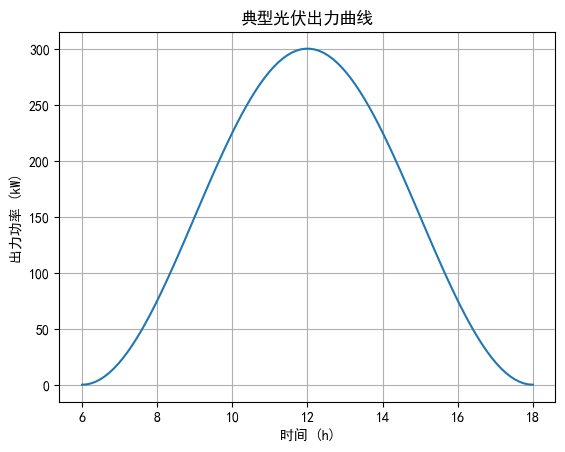

C:\Users\diego\AppData\Local\Temp\ipykernel_35216\2865590537.py:30: TqdmExperimentalWarning: rich is experimental/alpha
  for cap in tqdm(capacities, desc="问题3：PV容量仿真"):


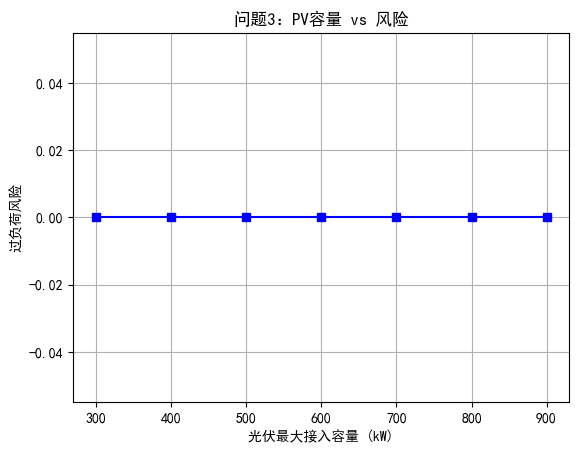

In [ ]:
def problem3():
    """问题3：光伏典型出力下，不同最大接入容量对系统风险影响"""

    # 典型光伏出力曲线展示
    t = np.linspace(6, 18, 100)
    P_pv = 300 * np.sin(np.pi * (t - 6) / 12) ** 2

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

    plt.plot(t, P_pv)
    plt.title("典型光伏出力曲线")
    plt.xlabel("时间 (h)")
    plt.ylabel("出力功率 (kW)")
    plt.grid()
    plt.show()

    node_id = "32"  # 注意：nodes_info 的 key 是字符串
    capacities = np.linspace(300, 900, 7)
    risks = []

    # 找到与该节点相连的第一个邻居
    neighbor = None
    for edge_dict in edges_info:
        (u, v) = list(edge_dict.keys())[0]
        if str(u) == node_id:
            neighbor = v
            break
        elif str(v) == node_id:
            neighbor = u
            break

    for cap in tqdm(capacities, desc="问题3：PV容量仿真"):
        # 深拷贝nodes_info，避免影响原始数据
        nodes_info_sim = json.loads(json.dumps(nodes_info))
        nodes_info_sim[node_id]["power"] = cap

        analyzer = RiskAnalyzer(nodes_info_sim, edges_info)
        if neighbor is not None:
            line = (int(node_id), int(neighbor))
            risks.append(analyzer.overload_risk(line))
        else:
            risks.append(0)

    plt.plot(capacities, risks, 'b-s')
    plt.xlabel("光伏最大接入容量 (kW)")
    plt.ylabel("过负荷风险")
    plt.title("问题3：PV容量 vs 风险")
    plt.grid()
    plt.show()
problem3()

C:\Users\diego\AppData\Local\Temp\ipykernel_35216\1936336820.py:24: TqdmExperimentalWarning: rich is experimental/alpha
  for cap in tqdm(capacities, desc="问题4：储能对比仿真"):


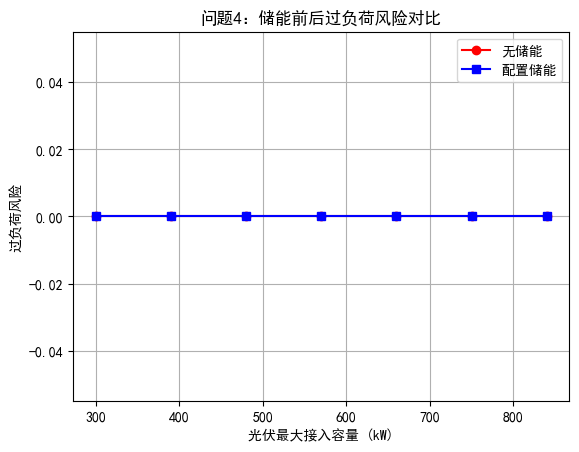

In [10]:
def problem4():
    """问题4：在光伏节点配置 15% 储能前后的风险比较"""
    node_id = "32"  # 注意：nodes_info 的 key 是字符串

    def apply_storage(node, ratio=0.15):
        """将原光伏容量削减 ratio 的比例用于储能吸纳"""
        node["power"] *= (1 - ratio)

    capacities = np.arange(300, 901, 90)
    risks_no_storage = []
    risks_with_storage = []

    # 找到与该节点相连的第一个邻居
    neighbor = None
    for edge_dict in edges_info:
        (u, v) = list(edge_dict.keys())[0]
        if str(u) == node_id:
            neighbor = v
            break
        elif str(v) == node_id:
            neighbor = u
            break

    for cap in tqdm(capacities, desc="问题4：储能对比仿真"):
        # 不带储能
        nodes_info_sim = json.loads(json.dumps(nodes_info))
        nodes_info_sim[node_id]["power"] = cap
        analyzer = RiskAnalyzer(nodes_info_sim, edges_info)
        if neighbor is not None:
            line = (int(node_id), int(neighbor))
            risks_no_storage.append(analyzer.overload_risk(line))
        else:
            risks_no_storage.append(0)

        # 带储能
        nodes_info_sim_storage = json.loads(json.dumps(nodes_info))
        nodes_info_sim_storage[node_id]["power"] = cap
        apply_storage(nodes_info_sim_storage[node_id])
        analyzer_storage = RiskAnalyzer(nodes_info_sim_storage, edges_info)
        if neighbor is not None:
            risks_with_storage.append(analyzer_storage.overload_risk(line))
        else:
            risks_with_storage.append(0)

    plt.plot(capacities, risks_no_storage, 'r-o', label="无储能")
    plt.plot(capacities, risks_with_storage, 'b-s', label="配置储能")
    plt.xlabel("光伏最大接入容量 (kW)")
    plt.ylabel("过负荷风险")
    plt.title("问题4：储能前后过负荷风险对比")
    plt.legend()
    plt.grid()
    plt.show()
problem4()